# 1. PREPARANDO NUESTRA BASE DE DATOS.

In [ ]:
import pandas as pd
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
echonest_metrics = pd.read_json('echonest-metrics.json', precise_float=True)
echo_tracks = pd.merge(
    echonest_metrics[['track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']],
    tracks[['track_id', 'genre_top']],
    on='track_id', 
    how='inner')
echo_tracks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


# 2. RELACIONES POR PARES ENTRE VARIABLES CONTINUAS.

In [ ]:
corr_metrics = echo_tracks.corr(numeric_only=True)

corr_metrics.style.background_gradient()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# 3. DIVIDIENDO NUESTROS DATOS.

In [ ]:
from sklearn.model_selection import train_test_split

features = echo_tracks.drop(columns=['track_id', 'genre_top'])
labels = echo_tracks['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

print(train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)


(3601, 8) (1201, 8) (3601,) (1201,)


# 4. NORMALIZACION DE LOS DATOS DE CARACTERISTICAS

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

print(scaled_train_features.shape, scaled_test_features.shape)


(3601, 8) (1201, 8)


# 5. ANALISIS DE COMPONENTES PRINCIPALES DE LOS DATOS ESCALADOS.

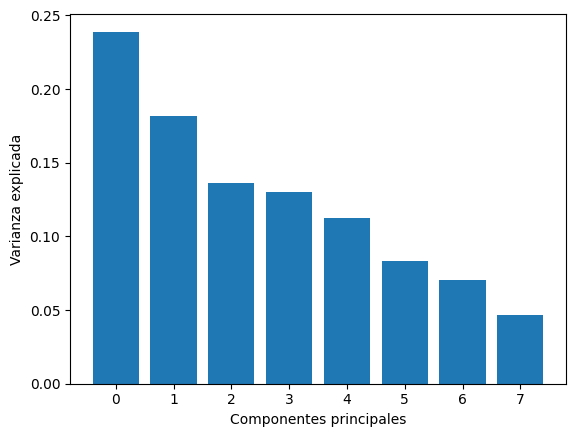

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca.fit(scaled_train_features)

exp_variance = pca.explained_variance_ratio_

plt.bar(range(len(exp_variance)), exp_variance)
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.show()



# 6. Visualización adicional de PCA.

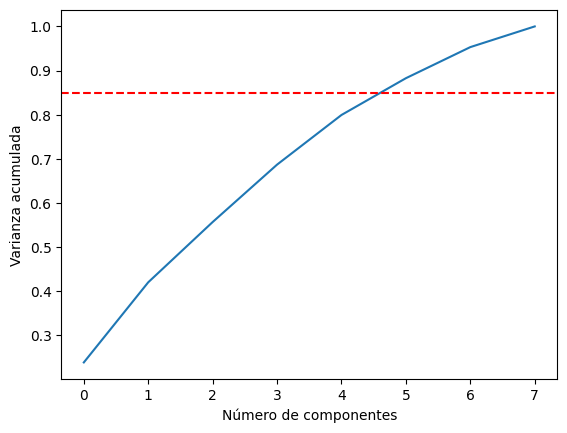

In [17]:
cum_exp_variance = np.cumsum(exp_variance)

plt.plot(cum_exp_variance)
plt.axhline(y=0.85, color='r', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.show()


# 7 PROYECTANDO SOBRE NUESTRAS CARACTERISTICAS

In [18]:
pca = PCA(n_components=6, random_state=10)
train_pca = pca.fit_transform(scaled_train_features)
test_pca = pca.transform(scaled_test_features)

print(train_pca.shape, test_pca.shape)


(3601, 6) (1201, 6)


# 8. ENTRENANDO UN ÁRBOL DE DECISIÓN PARA CLASIFICAR EL GÉNERO.

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)

pred_labels_tree = tree.predict(test_pca)

print(pred_labels_tree.shape)


(1201,)


# 9. COMPARAR NUESTRO ÁRBOL DE DECISIONES CON UNA REGRESIÓN LOGÍSTICA

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(random_state=10, max_iter=1000) 
logreg.fit(train_pca, train_labels)

pred_labels_logit = logreg.predict(test_pca)

class_rep_tree = classification_report(test_labels, pred_labels_tree)

class_rep_log = classification_report(test_labels, pred_labels_logit)


print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)



Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.62      0.60      0.61       235
        Rock       0.90      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.76      0.76      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



# 10. EQUILIBRAR NUESTROS DATOS PARA UN MAYOR RENDIMIENTO

In [29]:
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']
rock_only = rock_only.sample(n=len(hop_only), random_state=10)

rock_hop_bal = pd.concat([rock_only, hop_only], ignore_index=True)

features_bal = rock_hop_bal.drop('genre_top', axis=1)
labels_bal = rock_hop_bal['genre_top']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(features_bal, labels_bal, test_size=0.25, random_state=10)

scaled_train_features_bal = scaler.fit_transform(X_train_bal)
scaled_test_features_bal = scaler.transform(X_test_bal)

train_pca_bal = pca.fit_transform(scaled_train_features_bal)
test_pca_bal = pca.transform(scaled_test_features_bal)

# Visualizar la dimensión de los datos transformados
print("Dimensiones de los datos de entrenamiento (PCA):", train_pca_bal.shape)
print("Dimensiones de los datos de prueba (PCA):", test_pca_bal.shape)


Dimensiones de los datos de entrenamiento (PCA): (1365, 6)
Dimensiones de los datos de prueba (PCA): (455, 6)


# 11. ¿EQUILIBRANDO NUESTRO CONJUNTO DE DATOS MEJORA EL SESGO DEL MODELO?

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca_bal, y_train_bal) 

pred_labels_tree_bal = tree.predict(test_pca_bal) 

logreg = LogisticRegression(random_state=10, max_iter=1000) 
logreg.fit(train_pca_bal, y_train_bal)

pred_labels_logit_bal = logreg.predict(test_pca_bal)

class_rep_tree_bal = classification_report(y_test_bal, pred_labels_tree_bal)
class_rep_log_bal = classification_report(y_test_bal, pred_labels_logit_bal)

print("Decision Tree (Balanced): \n", class_rep_tree_bal)
print("Logistic Regression (Balanced): \n", class_rep_log_bal)


Decision Tree (Balanced): 
               precision    recall  f1-score   support

     Hip-Hop       0.78      0.78      0.78       230
        Rock       0.77      0.77      0.77       225

    accuracy                           0.78       455
   macro avg       0.78      0.78      0.78       455
weighted avg       0.78      0.78      0.78       455

Logistic Regression (Balanced): 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.80      0.81       230
        Rock       0.80      0.82      0.81       225

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       455
weighted avg       0.81      0.81      0.81       455

